<div style="display: block; width: 100%; height: 120px;">

<p style="float: left;">
    <span style="font-weight: bold; line-height: 24px; font-size: 16px;">
        DIGHUM160 - Critical Digital Humanities
        <br />
        Digital Hermeneutics 
    </span>
    <br >
    <span style="line-height: 22x; font-size: 14x; margin-top: 10px;">
        Week 3: Topic modeling<br />
        Created by Tom van Nuenen (tom.van_nuenen@kcl.ac.uk)
    </span>
</p>

# Topic modeling


Topic modeling is a type of statistical modeling for the discovery of abstract "topics" that occur in a collection of documents. It is frequently used in NLP to aid the discovery of hidden semantic structures in a collection of texts.

There are lots of Python packages for topic modeling. We will use Scikit-LEARN. 
If you have access to your Reddit dataset, feel free to use that instead.

The example dataset once again comes from the banned subreddit "The Red Pill".

Today, we'll try to improve our topic modeling. We'll use the `Gensim` package to create our topic models, as it allows us to run tests to optimize our topic amount.

After reading this notebook, you'll be able to:

* Create and visualise topic models using Scikit-LEARN;
* Close read top documents associated with topics of interest;
* Use gensim to create topic models;
* Evaluate topic models using several methods.


In [ ]:
import logging
import string
import os
import pickle
from pprint import pprint
import re 
import numpy as np
import pandas as pd
from IPython.display import clear_output
from more_itertools import chunked

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Gensim
from gensim import corpora, models, similarities
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import gensim

# SpaCy 
import spacy

# Plotting tools
!pip install pyLDAvis
import pyLDAvis.sklearn 
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

#SKLearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text

# Suppressing warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Getting the data

We'll use the same two datasets as we did in the last notebook: comments and submissions from The Red Pill.

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':"1hN5eqCYVZOX_O0i8waJUQxDlJjqDMenK"})   # replace the id with id of file you want to access
downloaded.GetContentFile('TRP_submissions.csv')       

In [ ]:
downloaded = drive.CreateFile({'id':"1nY9JtXoGJa7B-OmU6afh4qfcFGPCQIHW"})   # replace the id with id of file you want to access
downloaded.GetContentFile('TRP_comments.csv')        

In [ ]:
trp_sub = pd.read_csv("TRP_submissions.csv", lineterminator='\n')
trp_com = pd.read_csv("TRP_comments.csv", lineterminator='\n')

Get rid of the empty cells in our two DataFrames using the `trp_sub[~trp_sub['selftext'].isin(['[removed]', '[deleted]' ])]` and `.dropna(subset=['selftext'])` (for the submissions DF) and `.dropna(subset=['body'])` (for the comments DF).

In [ ]:
# Your code here





## Concatenating submissions and comments

For the topic model we're going to make, we will first concatenate the associated submissions and comments (i.e., the threads).

Using the `pd.merge()` method, we can do an "inner join" of our two DataFrames. This is a relational database operation, which is a common operation in SQL. See [here](https://www.w3schools.com/sql/sql_join.asp) if you want to learn more. An "inner join" will yield a new DF which only contains those submissions that have associated comments (based on their "idstr" and "parent" values).

![alt text](https://s33046.pcdn.co/wp-content/uploads/2019/06/venn-diagram-representation-of-sql-inner-join-.png)

In [ ]:
# merge DF based on idstr and parent
trp_t = pd.merge(trp_sub, trp_com, how='inner', left_on='idstr', right_on='parent')

We now have a DataFrame containing all original posts / submissions, *and* the comments associated with this original post! Note that this yields a lot of rows with the same "selftext" value (as lots of comments refer to the same original post).

Also note that this operations has changed the names of the columns: we now have "x" and "y" columns based on the original DataFrame we took the data from. "idstr_x", for instance, refers to the "idstr" column from the `trp_sub` DataFrame.

In [ ]:
trp_t.head()

Now, let's iterate over our merged DataFrame and group all associated submissions and comments together. 
- We first create an empty dictionary.
- We then iterate over our DataFrame using the Pandas `.iterrows()` method, which allows us to iterate over rows in a DataFrame in a for-loop. It yields a tuple consisting of the index and the row.
- `If` the "idstr_x" column does not yet exist in the keys of our new dictionary, add it. As the value, add the "selftext" (i.e., the original post) and "body" (i.e., the first comment) columns.
- `Else`, if we have the key already, only add the "body" column (i.e., the comment). 

In [ ]:
data_d = {}
for i, r in trp_t.iterrows():
    if r.idstr_x not in data_d.keys():
        data_d[r.idstr_x] = [r.selftext, r.body]    
    else:
        data_d[r.idstr_x].append(r.body)    

In [ ]:
# See if it works
data_d['t3_6sbx6i']

Finally, we'll join the items in each of the values in our `dict` and put that in a list:

In [ ]:
data = ['\n'.join(thread) for thread in data_d.values()]

## Preprocessing

First, let's get rid of the newlines. Iterate over each text in our `data` list, and use string replacements or RegEx to remove the newlines.

In [ ]:
# Your code here


Time to tokenize. Let's use Gensim's `simple_preprocess()` method this time. If you haven't seen `yield` before, it is used in what's called a generator function. This is simply a function that iterates, instead of only returning something once.

`Return` sends a specified value back to its caller whereas `yield` can produce a sequence of values. We should use `yield` when we want to iterate over a sequence, but don’t want to store the entire sequence in memory.

In [ ]:
def tokenizer(texts):
    for text in texts:
        yield(gensim.utils.simple_preprocess(str(text), deacc=True))  # deacc=True removes punctuations
tokens_list = list(tokenizer(data))

How many threads do we have?

In [ ]:
len(tokens_list)

And how many tokens in total?

In [ ]:
counter = 0
for each in tokens_list:
    counter += len(each)
counter

In [ ]:
tokens_list[1][:10]

## Exracting N-grams with gensim

Topic modeling – as well as many other kinds of NLP methods – works better when using N-grams, as this allows words that frequently appearing together to be concatenated (e.g. "red pill" means something different than "red" and "pill" separately).

Gensim’s `Phrases` model implements bigrams, trigrams, quadgrams, etc. 

`Phrases` detects phrases based on collocation counts. It builds a model of input text that you then can use on other data.

Gensim detects a bigram if a scoring function for two words exceeds a threshold. The two important arguments to `Phrases` are `min_count` and `threshold`. The higher the values of these parameters, the harder it is for words to be combined to bigrams.

In [ ]:
# Build bigram and trigram models
# min_count = min amount of tokens/bigrams in corpus. Threshold = score-based; higher = fewer phrases.
bigram = gensim.models.Phrases(tokens_list, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[tokens_list], threshold=100)  

# `Phraser` must be built from an initial `Phrases` instance. 
# It then works faster while using much less memory. See https://radimrehurek.com/gensim/models/phrases.html
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
print(trigram_mod[bigram_mod[tokens_list[0]]])

Let's define some functions for stopword removal, making bigrams and trigrams, and lemmatization (we will use SpaCy for the latter - see [here](https://spacy.io/api/annotation) for more info).


In [ ]:
# prepare NLTK stopwords
stop = set(stopwords.words('english') + ['’', '“', '”', 'nbsp', 'http'])

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop] for doc in texts]
      
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for doc in texts:
        joined = nlp(" ".join(doc)) 
        texts_out.append([token.lemma_ for token in joined if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove stopwords
tokens_no_stops = remove_stopwords(tokens_list)

# Form trigrams
trigrams = make_trigrams(tokens_no_stops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization 
lemmas = lemmatization(trigrams)


In [ ]:
lemmas[1][:10]

### Pickling
We've done a lot of work, so let's save this object in a pickle. Any object in Python can be pickled so that it can be saved on disk (or in this case, a virtual disk). What pickle does is that it “serializes” the object first before writing it to file. Pickling is a way to convert a python object (list, dict, etc.) into a character stream. The idea is that this character stream contains all the information necessary to reconstruct the object in another python script – or to fetch it at a later time when you don't want to do the computing work all over again.

Note that when pickling, you can use any file extension name you want.

In [ ]:
# Save to disk
with open("TRP_nouns.text", "wb") as docP: 
    pickle.dump(lemmas, docP)

In [ ]:
!ls

adc.json  sample_data  TRP_comments.csv  TRP_nouns.text  TRP_submissions.csv


In [ ]:
# should you want to load in the pickle we just saved:
with open("TRP_nouns.text", "rb") as docP: 
    lemmas = pickle.load(docP)

## Creating a `Dictionary` with Gensim

Now, let's create our gensim dictionary - a mapping of each word to a unique id. 
It will be used to create a `Corpus` object, which is gensim’s equivalent of a Document-Term matrix.

In [ ]:
# Create Dictionary 
dictionary = corpora.Dictionary(lemmas)

# Create Corpus, i.e. Document-Term Matrix
corpus = [dictionary.doc2bow(text) for text in lemmas]

*Note that Gensim allows you to run the `.add_documents` method that will append additional documents to your `dictionary`, if you need to.*

Let's view some of the corpus we have now:

In [ ]:
print(corpus[0][:10])

Observe the first 10 tuples above. Each consists of words with a unique id. This a mapping of (word_id, word_frequency). For example, (0, 1) above demonstrates that word id 0 occurs once in the first document. Word id 5 occurs 4 times, and so on. This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [ ]:
dictionary[5]

And if you want to see the associated id for some word:

In [ ]:
dictionary.token2id['advance']

## Running an LDA model

Now, let's run a Gensim LDA model:

In [ ]:
## Build LDA model. Make sure to play around with chunksize and passes and check if coherence score changes a lot.

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=20, 
                                           random_state=100,
                                           # eval_every = 20, # this is evaluation, perplexity
                                           update_every=1,
                                           chunksize=500,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## Visualizing the model

Let's try to evaluate our topics. First, we can visualize our topics using pyLDAvis. A "good" topic model produces non-overlapping, fairly large bubbles, which should be scattered throughout the chart instead of being clustered in one quadrant. A model with too many topics will typically have many overlaps, small sized bubbles clustered in one region of the chart. **This is the first way in which you can evaluate your topic models**.

In [ ]:
# Let's visualize our topics
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
panel

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.220531  0.102168       1        1  25.858065
15     0.240727 -0.033092       2        1  18.299891
10     0.272544 -0.139185       3        1  14.131565
13     0.191298 -0.039752       4        1   7.479117
7      0.191661 -0.048666       5        1   5.211764
11     0.070139  0.276161       6        1   5.115842
3      0.129211 -0.212599       7        1   4.586832
14     0.186582 -0.069523       8        1   4.466171
6      0.018892  0.230913       9        1   2.673299
18    -0.048016  0.086488      10        1   2.175429
2     -0.017162  0.054497      11        1   1.931779
1     -0.018396  0.119871      12        1   1.813591
9     -0.087562  0.147283      13        1   1.779927
12    -0.016265 -0.134628      14        1   1.582323
0     -0.190211 -0.097815      15        1   0.877904
5     -0.208479 -0.037304      16        1   0.556254
19    -0.228509 -0.073325      17        1   0.484775
8     -0.214808 -0.015127      18        1   0.453247
17    -0.247137 -0.051890      19        1   0.291118
16    -0.245038 -0.064475      20        1   0.231092, topic_info=             Term          Freq         Total Category  logprob  loglift
397         woman  26744.000000  26744.000000  Default  30.0000  30.0000
206           man  17039.000000  17039.000000  Default  29.0000  29.0000
519          girl   9789.000000   9789.000000  Default  28.0000  28.0000
160           guy   9600.000000   9600.000000  Default  27.0000  27.0000
317           sex   5143.000000   5143.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
5952  consumerism      4.563734      7.396715  Topic20  -5.7489   5.5872
2098   narcissism      6.780928     24.142542  Topic20  -5.3529   4.8002
6702   narcissist      6.554548     26.220215  Topic20  -5.3868   4.6837
241         other     10.755866   1051.143433  Topic20  -4.8916   1.4879
1418    structure      5.627110     98.529160  Topic20  -5.5394   3.2074

[1332 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1132      6  0.268415  abortion
1132     10  0.723554  abortion
9117      7  0.913258       abs
9117     15  0.081541       abs
1786      2  0.973955     abyss
...     ...       ...       ...
688      12  0.001680      year
688      13  0.007352      year
3594     16  0.856688      zinc
6400      9  0.154085    zombie
6400     15  0.821784    zombie

[3253 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 16, 11, 14, 8, 12, 4, 15, 7, 19, 3, 2, 10, 13, 1, 6, 20, 9, 18, 17])

### PyLDAvis graph

On the left, there is a 2D plot of the "distance" between all of the topics (labeled as the Intertopic Distance Map). This plot uses a multidimensional scaling (MDS) algorithm. 
- Similar topics should appear close together on the plot; dissimilar topics should appear far apart. 
- The relative size of a topic's circle in the plot corresponds to the relative frequency of the topic in the corpus.

### Exploring topics and words
- You can scrutinize a topic more closely by clicking on its circle, or entering its number in the "selected topic" box in the upper-left (Note that, though the data used by gensim and pyLDAvis are the same, they don't use the same ID numbers for topics.)
- If you roll your mouse over a term in the bar chart on the right, the topic circles will resize in the plot on the left. This shows the strength of the relationship between the topics and the selected term.

### Salience
On the right, there is a bar chart with the top terms. When no topic is selected in the plot on the left, the bar chart shows the top-30 most **salient** terms in the corpus. A term's saliency is a measure of both how frequent the term is in the corpus and how "distinctive" it is in distinguishing between different topics.

### Probability Vs Exclusivity 
When you select a particular topic, this bar chart changes to show the top-30 most "relevant" terms for the selected topic. The relevance metric is controlled by the parameter λ, which can be adjusted with a slider above the bar chart:

* Setting λ close to 1.0 (the default) will rank the terms according to their probability within the topic.
* Setting λ close to 0.0 will rank the terms according to their "distinctiveness" or "exclusivity" within the topic. This means that terms that occur only in this topic, and do not occur in other topics.

You can move the slider between 0.0 and 1.0 to weigh term probability and exclusivity.

## Assignment: Analyzing the pyLDA visualization

The interactive visualization pyLDAvis produces is helpful for both **individual** topics: you can manually select each topic to view its top most frequent and/or "relevant" terms, using different values of the λ parameter. This can help when you're trying to assign a name or "meaning" to each topic. 

It also helps you to see the **relationships** between topics: exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

See if you can make sense of the patterns you are seeing. Can you give an explanation for the distance between certain topics?

## Calculating Topic Coherence and Perplexity

Next, we can apply some statistical measures to help us determine the optimal number of topics in our topic model.

**Topic Coherence** is a measure applied to the top N words from each topic. It is defined as the average / median of the pairwise word-similarity scores of the words in the topic. This helps to distinguish between topics that are semantically interpretable topics, and topics that are artifacts of statistical inference. 

A set of statements or facts is said to be coherent if the statements support each other. An example of a coherent fact set is “the game is a team sport”, “the game is played with a ball”, “the game demands great physical efforts”

A good model will generate topics with *high* topic coherence scores. Good topics are topics that can be described by a short label, therefore this is what the topic coherence measure should capture.

There are different ways to calculate semantic similarity, e.g. through normalized pointwise mutual information (NPMI) or through cosine similarity.

**Perplexity** is a measure of how well a probability model predicts a sample.
It captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set. The model with the *lowest* perplexity is generally considered the “best”. 

*The issue with perplexity is that it tends to not be strongly correlated to human judgment and, even sometimes slightly anti-correlated. Therefore, we'll work with coherence scores*.

In [ ]:
%%time
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # A measure of how good the model is. The lower the better.

# Compute Coherence Score
coherence_model = CoherenceModel(model=lda_model, corpus=corpus, texts=lemmas, dictionary=dictionary, coherence='c_v') 
# The higher the better. A coherence score of .4 means probably not right number of topics; .6 is great. Anything more is suspiciously great.
coherence = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence)

There's no hard or fast rule on what makes a good coherence or perplexity score. We have to compare this for different iterations of our topic model (using different amounts of topics) to see which one works best.

## Optimizing coherence scores

The most obvious thing we can do to find optimal scores is to play around with the amount of topics our model creates. One way to do this is to build many LDA models with different values of number of topics (k), and then pick the one that gives the highest coherence value. Choosing a ‘k’ at the end of a rapid growth of topic coherence usually yields meaningful and interpretable topics. If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

This `compute_coherence_values()` function trains multiple LDA models, provides the models, and tells you their corresponding coherence scores.

Also note the docstring I create here: these are documentation for the functions we create. It describes what a function does, and can be called using `help(function_X)`.

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    total_amount = limit / step
    current_amount = 0
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, 
                                chunksize=500, passes=10, alpha='auto', per_word_topics=False)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        # When using 'c_v' texts should be provided, corpus isn’t needed. 
        # When using ‘u_mass’ corpus should be provided, if texts is provided, it will be converted to corpus using the dictionary 
        coherence_values.append(coherencemodel.get_coherence())
        current_amount += 1
        print("Built " + str(current_amount) + " of " + str(total_amount) + " models")

    return model_list, coherence_values


In [ ]:
help(compute_coherence_values)

Help on function compute_coherence_values in module __main__:

compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3)
    Compute c_v coherence for various number of topics
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics



Using our new function, let's run a bunch of topic models with different amounts of topics.
Note that this will take a long time, so if you don't want to wait 10 minutes, just see the output below.

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=lemmas, start=10, limit=100, step=10)

Built 1 of 10.0 models
Built 2 of 10.0 models
Built 3 of 10.0 models
Built 4 of 10.0 models
Built 5 of 10.0 models
Built 6 of 10.0 models
Built 7 of 10.0 models
Built 8 of 10.0 models
Built 9 of 10.0 models


Now, from all those models, let's visualize the output of the coherence scores.

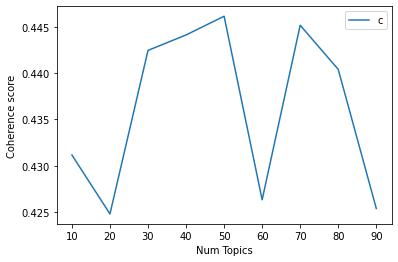

In [ ]:
# Show graph
limit=100; start=10; step=10;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print these coherence scores
for m, cv in zip(x, coherence_values):
    print(" Num Topics =", m, "Coherence Value =", round(cv, 4))

 Num Topics = 10 Coherence Value = 0.4312
 Num Topics = 20 Coherence Value = 0.4248
 Num Topics = 30 Coherence Value = 0.4425
 Num Topics = 40 Coherence Value = 0.4441
 Num Topics = 50 Coherence Value = 0.4461
 Num Topics = 60 Coherence Value = 0.4263
 Num Topics = 70 Coherence Value = 0.4452
 Num Topics = 80 Coherence Value = 0.4404
 Num Topics = 90 Coherence Value = 0.4254


If the coherence score seems to keep increasing, it generally makes sense to pick the model that gave the highest CV before dropping again. We'll pick the most fitting amount of topics to continue our research.

In [ ]:
# Select the ideal model and print the topics
optimal_model = model_list[4] # use lda_model if you've skipped the compute_coherence_values step 
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

[(2,
  '0.136*"priest" + 0.051*"philosophy" + 0.032*"doll" + 0.030*"gynocentricism" '
  '+ 0.027*"robot" + 0.020*"expectation" + 0.020*"brevity" + 0.018*"shadow" + '
  '0.015*"ldr" + 0.015*"handout" + 0.012*"bullshitting" + 0.011*"bask" + '
  '0.011*"application" + 0.011*"actualization" + 0.010*"hurrrr" + '
  '0.010*"devaluing" + 0.010*"porshe" + 0.010*"repaint" + 0.010*"kdmaxahkdxq" '
  '+ 0.010*"asceticism"'),
 (32,
  '0.027*"videogame" + 0.023*"surveillance" + 0.020*"begging" + '
  '0.019*"theater" + 0.017*"fulfill" + 0.017*"superstar" + 0.014*"stab" + '
  '0.014*"pre" + 0.013*"health_insurance" + 0.013*"password" + '
  '0.012*"single_moms" + 0.010*"direction" + 0.009*"amused_mastery" + '
  '0.008*"upfront" + 0.008*"pr" + 0.008*"footage" + 0.008*"large_amount" + '
  '0.008*"designer" + 0.008*"samantha" + 0.008*"sailor"'),
 (18,
  '0.057*"lab" + 0.034*"glass" + 0.029*"tiger" + 0.026*"disability" + '
  '0.025*"template" + 0.024*"nofap" + 0.016*"freelance" + 0.015*"turtle" + '
  '0.015

## Labeling the topic model

Topics are generated without a label; that part is up to us. Let's label our individual topics using a function. The function will ask for a label for each of the topics, which it will save to a `dict`.

You can use this dict with values in the other functions we'll create, and when providing visualisations.

In [ ]:
def explore_topic(topic_n, topn=25):
    """
    Accept a user-supplied topic number and print out a formatted list of the top terms.
    Allow use input to create dict for topic names
    """
    topic_dict = {}
    for n in range(topic_n):
        print('TOPIC ' + str(n))
        print('{:20} {}'.format('term', 'frequency') + '\n')
        for term, frequency in lda_model.show_topic(n, topn=25):
            print('{:20} {:.3f}'.format(term, round(frequency, 3)))
        topic_dict[n] = input("Topic label")
        clear_output()
    return topic_dict

In [ ]:
topic_dict = explore_topic(optimal_model.num_topics)

## Finding most dominant topic per thread

One of the practical application of topic modeling is to determine what topic a given Reddit thread is about. To figure this out, we find the topic number that has the highest percentage contribution in that thread. We'll write a `dominant_topic()` function that aggregates this information in a presentable table.

In [ ]:
def dominant_topic(ldamodel=optimal_model, corpus=corpus, texts=lemmas):
    # Create DF
    thread_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each thread
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                thread_topics_df = thread_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    thread_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    thread_topics_df = pd.concat([thread_topics_df, contents], axis=1)
    return(thread_topics_df)

df_topic_thread_keywords = dominant_topic(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_thread_keywords.reset_index()
df_dominant_topic.columns = ['Thread_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

## Finding most distinctive threads per topic

We can also find the threads that include the highest amount of words for a certain topic. You could use this if you have found a really interesting topic, and you want to know the top threads this topic is typically found in. The "Topic_Perc_Contrib" columns shows the topic number that has the highest percentage contribution in that document.

In [ ]:
# Group top 5 threads under each topic
thread_topics_sorteddf = pd.DataFrame()

thread_topics_outdf_grpd = df_topic_thread_keywords.groupby('Dominant_Topic')

for i, grp in thread_topics_outdf_grpd:
    thread_topics_sorteddf = pd.concat([thread_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                            axis=0)

# Reset Index    
thread_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
thread_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
thread_topics_sorteddf

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3404,"porn, pleasure, addiction, brain, dopamine, ho...","Edit: please read slowly, to absorb everything..."
1,0.0,0.3379,"porn, pleasure, addiction, brain, dopamine, ho...",**INTRODUCTION** &nbsp; Let me delve into a to...
2,0.0,0.3152,"porn, pleasure, addiction, brain, dopamine, ho...",**Intro:** After being sceptical for so long i...
3,0.0,0.2953,"porn, pleasure, addiction, brain, dopamine, ho...",I appreciate the recent post by u/throwmebaba ...
4,0.0,0.2861,"porn, pleasure, addiction, brain, dopamine, ho...",Summary: Getting to know the addict I had been...
...,...,...,...,...
147,47.0,0.4890,"month, year, relationship, friend, time, ex, b...",I recently posted about my two year LTR learni...
148,47.0,0.4126,"month, year, relationship, friend, time, ex, b...",Heres an archive of the thread. http://archive...
149,47.0,0.4047,"month, year, relationship, friend, time, ex, b...",Sorry if I do something wrong this is my fist ...
150,47.0,0.3957,"month, year, relationship, friend, time, ex, b...",This is a Field Report from a cousin in Mexico...


In [ ]:
thread_topics_sorteddf['Text'][4]

'Summary: Getting to know the addict I had been playing Xbox since I woke up 15 hours ago. Two empty Dominos pizza boxes sat open on my desk just staring. Right now its 5 a.m. Matchmaking is getting slow and my coffee thermos is empty; must be time for bed. I say goodnight to my fellow gamers and turn off the Xbox. The thought of brushing my teeth doesnt enter whats left of my consciousness. Without walking, I move from my chair to the bed. Two missed calls and a text from my girlfriend. The only source of light is the brightly lit screen of my laptop. As I type in "p," the text "pornhub.com" automatically appears in the URL of my browser. Im excited before I even press "enter." After finishing up, I close my eyes as YouTube lulls me to sleep. A voice inside mumbles, "I hate myself..." "If I hate myself, who is the I, and who is myself?" Tomorrow will be the same. Pleasure is what happens when your brain receives a signal that an activity is rewarding. The sender of that signal is a ne

## Optional assignment: using the topic names

If you want to dive a bit deeper into these functions, try to change the output so that it doesn't show the topic numbers, but the topic names from the `topic_dict` you created!
It will help you get a better understanding of what's going on.

In [ ]:
# Your code here










